# Biomass Proxy Planetary Variables from Subscriptions API

Accessing comprehensive and accurate environmental data is essential for optimizing agricultural practices and making informed decisions. The Biomass Proxy Planetary Variables dataset offers a wealth of information related to biomass dynamics, providing valuable insights into vegetation growth and crop health. In this example, you retrieve and analyze Biomass Proxy data using the Subscriptions API, through the process of data retrieval, filtering, manipulation, and visualization. By harnessing the capabilities of the Subscriptions API, you can effectively leverage the Biomass Proxy Planetary Variables dataset to gain valuable insights and enhance your understanding of ecological dynamics within your agricultural context.

## Planet API Authentication

Track the median biomass-proxy value over time to aide in monitoring the growth and development of soybean plants.


In [ ]:
from io import StringIO
import datetime as datetime

from dotenv import dotenv_values
import requests
from requests.auth import HTTPBasicAuth
import json

from shapely.geometry import shape
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.plot import show

import matplotlib.dates as mdates


In [3]:
# Get your Planet API Key from an environment variable
DOT_ENV_VALS = dotenv_values("../../.env")

# Your Planet API Key 
API_KEY = DOT_ENV_VALS["PL_API_KEY"] 

# Planet's Subscriptions API base URL for making restFUL requests
BASE_URL = "https://api.planet.com/subscriptions/v1"

In [4]:
# confirm that the API key is valid
auth = HTTPBasicAuth(API_KEY, '')
response = requests.get(BASE_URL, auth=auth)
response

<Response [200]>

## Creating a Planetary Variables Subscription with the Subscriptions API

To create a subscription using the Client, provide a JSON request object that includes required information such as source type, geojson, and others (link to the docs).


### Create your JSON subscription description object

Is your area of interest inside region of access for your contract with Planet? You can compare the two geojson objects using Shapely.

In [6]:
# Area of Interest (AOI) - Field in Ohio
AOI = {
    "type": "Polygon",
    "coordinates": [[[ -83.459351687641913, 40.187200874209744 ],
                     [ -83.452336405535007, 40.183794610065355 ],
                     [ -83.453350174625598, 40.18351075471999 ],
                     [ -83.454526146770689, 40.183835160828977 ],
                     [ -83.456796989533615, 40.182213130284033 ],
                     [ -83.459878847569016, 40.181888724175046 ],
                     [ -83.465069345312841, 40.176698226431213 ],
                     [ -83.493292676794908, 40.174751789777275 ],
                     [ -83.489602557305162, 40.176698226431213 ],
                     [ -83.483317188943488, 40.176698226431213 ],
                     [ -83.474963731637018, 40.180631650502711 ],
                     [ -83.470138190765795, 40.181564318066052 ],
                     [ -83.459351687641913, 40.187200874209744 ]
                  ]]
      }

# Area of Access (AOA) - United States
AOA = {
    "type": "Polygon",
    "coordinates": [[[ -126.9504, 46.5531],
                        [ -54.1833, 46.7628],
                        [ -77.8798, 24.3246],
                        [ -94.6561, 23.9051],
                        [ -124.2242, 34.1806],
                        [ -126.9504, 46.5531]
                    ]]
      }

# Determine if the AOI is inside the AOA
def is_inside(AOI, AOA):
    smaller_shape = shape(AOI)
    larger_shape = shape(AOA)
    
    return smaller_shape.within(larger_shape)

result = is_inside(AOI, AOA)
print(result)  # True


True


In [8]:
# Create a new subscription JSON object
subscription_desc = {
   "name": "TEST Soybean Ohio Field 3 yrs BIOMASS-PROXY_V3.0_10",
   "source": {
       "type": "biomass_proxy",
       "parameters": {
           "id": "BIOMASS-PROXY_V3.0_10",
           "start_time": "2020-01-15T00:00:00Z",
           "end_time": "2023-04-24T00:00:00Z",
           "geometry": {
               "coordinates": [[[ -83.459351687641913, 40.187200874209744 ],
                     [ -83.452336405535007, 40.183794610065355 ],
                     [ -83.453350174625598, 40.18351075471999 ],
                     [ -83.454526146770689, 40.183835160828977 ],
                     [ -83.456796989533615, 40.182213130284033 ],
                     [ -83.459878847569016, 40.181888724175046 ],
                     [ -83.465069345312841, 40.176698226431213 ],
                     [ -83.493292676794908, 40.174751789777275 ],
                     [ -83.489602557305162, 40.176698226431213 ],
                     [ -83.483317188943488, 40.176698226431213 ],
                     [ -83.474963731637018, 40.180631650502711 ],
                     [ -83.470138190765795, 40.181564318066052 ],
                     [ -83.459351687641913, 40.187200874209744 ]
                  ]],
               "type": "Polygon"
           }
       }
   }
}

In [9]:
# View the JSON object
subscription_desc

{'name': 'TEST Soybean Ohio Field 3 yrs BIOMASS-PROXY_V3.0_10',
 'source': {'type': 'biomass_proxy',
  'parameters': {'id': 'BIOMASS-PROXY_V3.0_10',
   'start_time': '2020-01-15T00:00:00Z',
   'end_time': '2023-04-24T00:00:00Z',
   'geometry': {'coordinates': [[[-83.45935168764191, 40.18720087420974],
      [-83.45233640553501, 40.183794610065355],
      [-83.4533501746256, 40.18351075471999],
      [-83.45452614677069, 40.18383516082898],
      [-83.45679698953361, 40.18221313028403],
      [-83.45987884756902, 40.181888724175046],
      [-83.46506934531284, 40.17669822643121],
      [-83.49329267679491, 40.174751789777275],
      [-83.48960255730516, 40.17669822643121],
      [-83.48331718894349, 40.17669822643121],
      [-83.47496373163702, 40.18063165050271],
      [-83.4701381907658, 40.18156431806605],
      [-83.45935168764191, 40.18720087420974]]],
    'type': 'Polygon'}}}}

### Create a subscription using your JSON subscription description object


In [9]:
# set content type to json
headers = {'content-type': 'application/json'}

# create a subscription
def subscribe_pv(subscription_desc, auth, headers):
    response = requests.post(BASE_URL, data=json.dumps(subscription_desc), auth=auth, headers=headers)
    print(response)
    subscription_id = response.json()['id']
    print(subscription_id)
    subscription_url = BASE_URL + '/' + subscription_id
    return subscription_url

pv_subscription = subscribe_pv(subscription_desc, auth, headers)

<Response [200]>
69b83d57-c885-464a-9a94-5c1d2bfacbd4


## Using the data from Planet

### Get the subscription

Here we check the status of the subscription we created. When it has the status `completed`, it'll be delivered to the bucket, above.


In [10]:
# Get the subscription ID - GCP bucket directory name where the data will be delivered
sub_id = requests.get(pv_subscription, auth=auth).json()['id']
# for example: sub_id = "69b83d57-c885-464a-9a94-5c1d2bfacbd4"

# Use sub_id to get the subscription state
def get_sub_status(sub_id, auth):
    sub_url = BASE_URL + '/' + sub_id
    sub_status = requests.get(sub_url, auth=auth).json()['status']
    return sub_status

# Note: Running the subscription may take a while depending 
# on the size of your AOI and the time range.
sub_status = get_sub_status(sub_id, auth)
sub_status


'completed'

Use the pandas library to read the CSV data into a DataFrame called df. Filter only valid data is retained in the DataFrame for further analysis or processing.


Next, you can retrieve data in CSV format from a specified URL using an API request. Then read the CSV data into a Pandas DataFrame. Use `item_datetime` in a datetime format and removes the timezone information. You can filter the DataFrame to include only rows where the month of `item_datetime` falls between May and November. You can also filter the DataFrame to keep only rows with valid data, excluding any rows with null or zero values for `bp.band-1.valid_percent`, as well as rows with a status of `QUEUED`. You have the option to assign a title value to the DataFrame from a subscription description. Finally, view the first few rows of the DataFrame to examine the data.


In [18]:
# Retrieve the resulting data in CSV format. 
resultsCSV = requests.get(f"{BASE_URL}/{sub_id}/results?format=csv", auth=auth)

# read the CSV data into a text file
with open('results.csv', 'w') as f:
    f.write(resultsCSV.text)

# Read CSV Data
df = pd.read_csv(StringIO(resultsCSV.text), parse_dates=["item_datetime", "local_solar_time"])

# Ensure 'item_datetime' is in datetime format and remove timezone
df['item_datetime'] = pd.to_datetime(df['item_datetime']).dt.tz_localize(None)

# Filter rows where the month of 'item_datetime' is between May and November
df = df[(df['item_datetime'].dt.month >= 5) & (df['item_datetime'].dt.month <= 11)]

# Filter rows where the month of 'item_datetime' is between May and November
df = df[(df['item_datetime'].dt.month >= 5) & (df['item_datetime'].dt.month <= 11)]

# Filter by valid data only
df = df[df["bp.band-1.valid_percent"].notnull()]
df = df[df["bp.band-1.valid_percent"] > 0]
df = df[df["status"] != 'QUEUED']

df.title = subscription_desc["name"]

df.head()


,id,item_datetime,status,created,updated,errors,bp.band-1.mean,bp.band-1.valid_percent,item_id,local_solar_time,source_id
107,fa301fbc-c6e5-43bd-ad83-17a2eaa468cc,2020-05-01 06:00:00,SUCCESS,2023-05-19T00:57:31.84027Z,2023-05-19T00:57:31.84027Z,{},0.36,100,BIOMASS-PROXY_V3.0_10_2020-05-01T0000,2020-05-01,BIOMASS-PROXY_V3.0_10
108,3cc6e545-5584-425f-b1d5-34d8331cbebf,2020-05-02 06:00:00,SUCCESS,2023-05-19T00:57:31.604393Z,2023-05-19T00:57:31.604393Z,{},0.36,100,BIOMASS-PROXY_V3.0_10_2020-05-02T0000,2020-05-02,BIOMASS-PROXY_V3.0_10
109,6faf2ad5-84a0-44e1-be8a-fcafaabbaf6b,2020-05-03 06:00:00,SUCCESS,2023-05-19T00:57:31.83281Z,2023-05-19T00:57:31.83281Z,{},0.36,100,BIOMASS-PROXY_V3.0_10_2020-05-03T0000,2020-05-03,BIOMASS-PROXY_V3.0_10
110,0d14b0e1-9384-4fda-b4c3-6cda2c3aaa17,2020-05-04 06:00:00,SUCCESS,2023-05-19T00:57:31.848121Z,2023-05-19T00:57:31.848121Z,{},0.35,100,BIOMASS-PROXY_V3.0_10_2020-05-04T0000,2020-05-04,BIOMASS-PROXY_V3.0_10
111,d414e34c-36d5-4bd7-b606-2e4543c529e4,2020-05-05 06:00:00,SUCCESS,2023-05-19T00:57:31.844406Z,2023-05-19T00:57:31.844406Z,{},0.35,100,BIOMASS-PROXY_V3.0_10_2020-05-05T0000,2020-05-05,BIOMASS-PROXY_V3.0_10


Next you can filter out invalid results from a dataframe, calculate the median biomass-proxy value for each date, and visualize the median values over time using a line plot.

item_datetime
2020-05-01    0.36
2020-05-02    0.36
2020-05-03    0.36
2020-05-04    0.35
2020-05-05    0.35
              ... 
2022-11-26    0.16
2022-11-27    0.16
2022-11-28    0.16
2022-11-29    0.16
2022-11-30    0.16
Name: bp.band-1.mean, Length: 642, dtype: float64


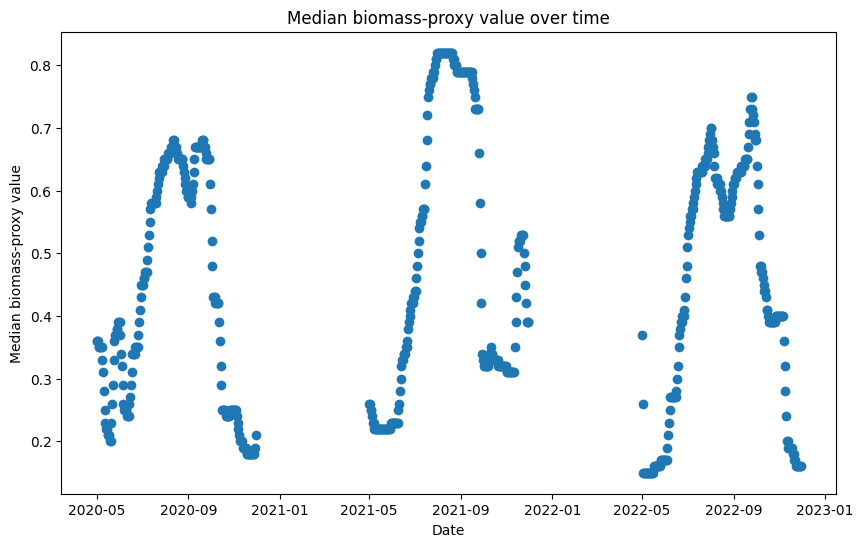

In [19]:
# Filter out the invalid results
df = df[df["bp.band-1.valid_percent"].notnull() & (df["bp.band-1.valid_percent"] > 0) & (df["status"] != 'QUEUED')]

# Group by date and compute the median for 'bp.band-1.mean' for each group
median_values = df.groupby(df['item_datetime'].dt.date)['bp.band-1.mean'].median()

print(median_values)

# Plot the results
median_values.plot(kind='line', figsize=(10, 6), style='o', title='Median biomass-proxy value over time')
plt.xlabel('Date')
plt.ylabel('Median biomass-proxy value')
plt.show()


This code first filters the dataframe to only include rows where the month of `item_datetime` is between May and November. Then, when plotting, it uses a pseudo year (2000, which is a leap year) for the x-axis to ensure the dates range from May 1st to October 31st. It also adds an additional line that represents the median of `bp.band-1.mean` across all years.

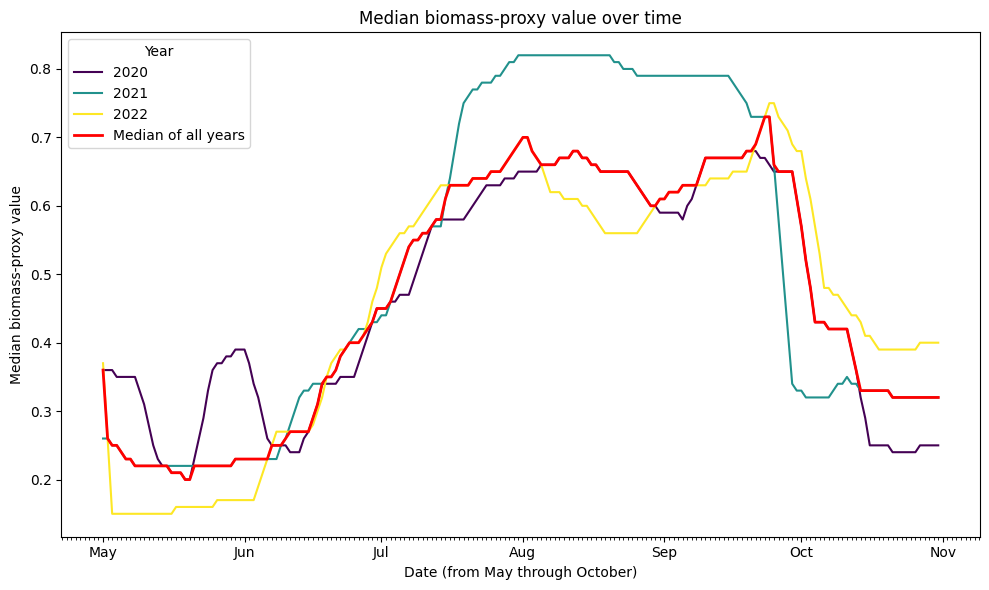

In [20]:
import numpy as np

# Filter rows where the month of 'item_datetime' is between May and November
df = df[(df['item_datetime'].dt.month >= 5) & (df['item_datetime'].dt.month < 11)]

# Add a separate column for the year
df['Year'] = df['item_datetime'].dt.year

# Extract only the month and day from the 'item_datetime' column
df['Month_Day'] = df['item_datetime'].apply(lambda x: x.strftime('%m-%d')) 

# Group by 'Year' and 'Month_Day' and compute the median for 'bp.band-1.mean' for each group
df_grouped = df.groupby(['Year', 'Month_Day'])['bp.band-1.mean'].median().reset_index()

# Add a pseudo year to 'Month_Day' for plotting
df_grouped['plot_date'] = df_grouped.apply(lambda row: pd.to_datetime(f'2000-{row.Month_Day}'), axis=1)

# Set plot_date as index for easy plotting
df_grouped.set_index('plot_date', inplace=True)

# Get the unique years for coloring
years = df_grouped['Year'].unique()

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(years)))

fig, ax = plt.subplots(figsize=(10, 6))

# Plot each year's data
for i, year in enumerate(years):
    df_year = df_grouped[df_grouped['Year'] == year]
    ax.plot(df_year.index, df_year['bp.band-1.mean'], color=colors[i], label=year)

# Compute and plot the median of all years
df_all_years_median = df_grouped.groupby(df_grouped.index)['bp.band-1.mean'].median()
ax.plot(df_all_years_median.index, df_all_years_median, color='red', label='Median of all years', linewidth=2)

# Format the x-axis to display months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.title('Median biomass-proxy value over time')
plt.xlabel('Date (from May through October)')
plt.ylabel('Median biomass-proxy value')
plt.legend(title='Year')
plt.tight_layout()
plt.show()
